<a href="https://colab.research.google.com/github/MattiaDelleani/MLDL_project/blob/master/resnet_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn


class block(nn.Module): # identity_downsample is a convLayer that we might need to adapt
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ): 
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)

        # ADDED:
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        # self.conv2 = nn.Conv2d(
        #     intermediate_channels,
        #     intermediate_channels,
        #     kernel_size=3,
        #     stride=stride,
        #     padding=1,
        #     bias=False
        # )
        # self.bn2 = nn.BatchNorm2d(intermediate_channels)
        # self.conv3 = nn.Conv2d(
        #     intermediate_channels,
        #     intermediate_channels * self.expansion,
        #     kernel_size=1,
        #     stride=1,
        #     padding=0,
        #     bias=False
        # )
        # self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # x = self.relu(x)
        # x = self.conv3(x)
        # x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )
      
        # layer that changes the number of channels
        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        ) 

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [7]:
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)



def ResNet32(img_channel=3, num_classes=1000):
    return ResNet(block, [2, 2, 2, 2], img_channel, num_classes)



torchvisoion


In [10]:
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [11]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [12]:
def resnet32(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet32', BasicBlock, [3, 4, 5, 3], pretrained, progress,
                   **kwargs)

In [13]:

def test():
    net = resnet32()
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(net)


test()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

BATCH ITERATOR


In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                # Cropping and possible flipping
                if (np.random.randint(2) > 0):
                    random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
                else:
                    random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)][:,:,::-1]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]
        
        yield inp_exc, targets[excerpt]

In [8]:
def accuracy_measure(X_valid, Y_valid, class_means, val_fn, top1_acc_list, iteration, iteration_total, type_data):
    
    stat_hb1   = []
    stat_icarl = []
    stat_ncm   = []
    
    for batch in iterate_minibatches(X_valid, Y_valid, min(500,len(X_valid)), shuffle=False):
        inputs, targets_prep = batch
        targets = np.zeros((inputs.shape[0],100),np.float32)
        targets[range(len(targets_prep)),targets_prep.astype('int32')] = 1.
        err,pred,pred_inter = val_fn(inputs, targets)
        pred_inter  = (pred_inter.T/np.linalg.norm(pred_inter.T,axis=0)).T
        
        # Compute score for iCaRL
        sqd         = cdist(class_means[:,:,0].T, pred_inter, 'sqeuclidean')                    
        score_icarl = (-sqd).T
        # Compute score for NCM
        sqd         = cdist(class_means[:,:,1].T, pred_inter, 'sqeuclidean')                    
        score_ncm   = (-sqd).T
        
        # Compute the accuracy over the batch
        stat_hb1   += ([ll in best for ll, best in zip(targets_prep.astype('int32'), np.argsort(pred, axis=1)[:, -1:])])
        stat_icarl += ([ll in best for ll, best in zip(targets_prep.astype('int32'), np.argsort(score_icarl, axis=1)[:, -1:])])
        stat_ncm   += ([ll in best for ll, best in zip(targets_prep.astype('int32'), np.argsort(score_ncm, axis=1)[:, -1:])])
    
    print("Final results on "+type_data+" classes:")
    print("  top 1 accuracy iCaRL          :\t\t{:.2f} %".format(np.average(stat_icarl)* 100))
    print("  top 1 accuracy Hybrid 1       :\t\t{:.2f} %".format(np.average(stat_hb1)* 100))
    print("  top 1 accuracy NCM            :\t\t{:.2f} %".format(np.average(stat_ncm)* 100))
    
    top1_acc_list[iteration,0,iteration_total] = np.average(stat_icarl) * 100
    top1_acc_list[iteration,1,iteration_total] = np.average(stat_hb1) * 100
    top1_acc_list[iteration,2,iteration_total] = np.average(stat_ncm) * 100
    
    return top1_acc_list

#LOADING DATA

In [ ]:
def load_data(samples_pr_cl_val):
    xs = []
    ys = []
    for j in range(1):
      d = unpickle('cifar-100-python/train')
      x = d['data']
      y = d['fine_labels']
      xs.append(x)
      ys.append(y)
    
    d = unpickle('cifar-100-python/test')
    xs.append(d['data'])
    ys.append(d['fine_labels'])
    
    x = np.concatenate(xs)/np.float32(255)
    y = np.concatenate(ys)
    x = np.dstack((x[:, :1024], x[:, 1024:2048], x[:, 2048:]))
    x = x.reshape((x.shape[0], 32, 32, 3)).transpose(0,3,1,2)
    # subtract per-pixel mean
    pixel_mean = np.mean(x[0:50000],axis=0)
    x -= pixel_mean
    # Create Train/Validation set
    eff_samples_cl = 500-samples_pr_cl_val
    X_train = np.zeros((eff_samples_cl*100,3,32, 32))
    Y_train = np.zeros(eff_samples_cl*100)
    X_valid = np.zeros((samples_pr_cl_val*100,3,32, 32))
    Y_valid = np.zeros(samples_pr_cl_val*100)
    for i in range(100):
        index_y=np.where(y[0:50000]==i)[0]
        np.random.shuffle(index_y)
        X_train[i*eff_samples_cl:(i+1)*eff_samples_cl] = x[index_y[0:eff_samples_cl],:,:,:]
        Y_train[i*eff_samples_cl:(i+1)*eff_samples_cl] = y[index_y[0:eff_samples_cl]]
        X_valid[i*samples_pr_cl_val:(i+1)*samples_pr_cl_val] = x[index_y[eff_samples_cl:500],:,:,:]
        Y_valid[i*samples_pr_cl_val:(i+1)*samples_pr_cl_val] = y[index_y[eff_samples_cl:500]]
    
    X_test  = x[50000:,:,:,:]
    Y_test  = y[50000:]
    
    return dict(
        X_train = lasagne.utils.floatX(X_train),
        Y_train = Y_train.astype('int32'),
        X_valid = lasagne.utils.floatX(X_valid),
        Y_valid = Y_valid.astype('int32'),
        X_test  = lasagne.utils.floatX(X_test),
        Y_test  = Y_test.astype('int32'),)


Mine

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

#### Augmentation

In [5]:
# Normalize training set together with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

# Normalize test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

#### Data Loading

In [6]:


batch_size = 128

trainset = torchvision.datasets.CIFAR100(root="./data",
                                         train=True,
                                         download=True,
                                         transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root="./data",
                                        train=False,
                                        download=True,
                                        transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import os
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt

%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


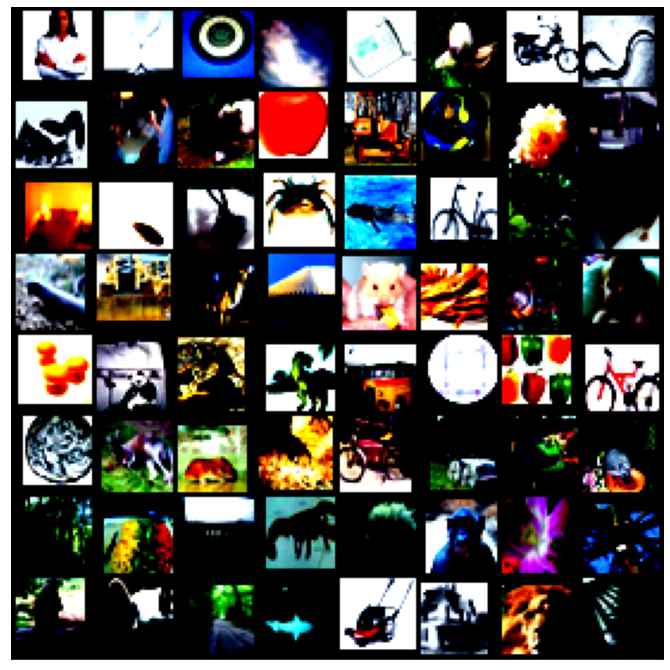

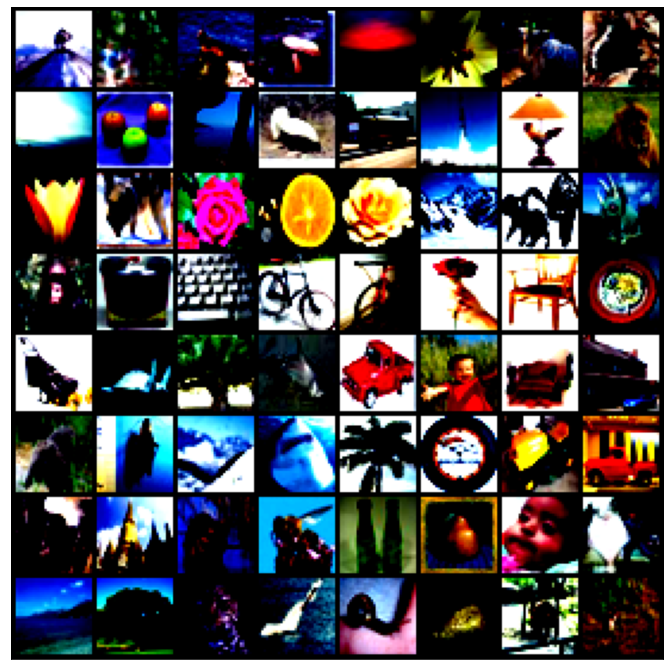

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(trainloader)
show_batch(testloader)

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
class CIFAR100Resnet(ImageClassificationBase):
        def __init__(self):
                super().__init__()
                self.network = resnet32()
                num_ftrs = self.network.fc.in_features
                self.network.fc = nn.Linear(num_ftrs, 100)
        
        def forward(self, xb):
                return self.network(xb)
            
model = CIFAR100Resnet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

model.to(device)

model = to_device(CIFAR100Resnet(), device)

cuda:0


In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, 
        weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
train_dl = DeviceDataLoader(trainloader, device)
test_dl = DeviceDataLoader(testloader, device)

In [28]:
opt_func=torch.optim.SGD

history = fit(25, 0.05, model, train_dl, test_dl, 5e-4, opt_func)

Epoch [0], train_loss: 4.0009, val_loss: 3.6255, val_acc: 0.1420
Epoch [1], train_loss: 3.4832, val_loss: 3.3897, val_acc: 0.1781
Epoch [2], train_loss: 3.2189, val_loss: 3.1493, val_acc: 0.2308
Epoch [3], train_loss: 3.0065, val_loss: 3.3454, val_acc: 0.2033
Epoch [4], train_loss: 2.8351, val_loss: 2.8922, val_acc: 0.2712
Epoch [5], train_loss: 2.6897, val_loss: 2.6952, val_acc: 0.3128
Epoch [6], train_loss: 2.5731, val_loss: 2.7887, val_acc: 0.3093
Epoch [7], train_loss: 2.4613, val_loss: 2.7198, val_acc: 0.3178
Epoch [8], train_loss: 2.3695, val_loss: 2.5090, val_acc: 0.3565
Epoch [9], train_loss: 2.2807, val_loss: 2.7401, val_acc: 0.3341
Epoch [10], train_loss: 2.2074, val_loss: 2.4282, val_acc: 0.3748
Epoch [11], train_loss: 2.1277, val_loss: 2.3879, val_acc: 0.3870
Epoch [12], train_loss: 2.0549, val_loss: 2.4205, val_acc: 0.3795
Epoch [13], train_loss: 1.9876, val_loss: 2.3325, val_acc: 0.4033
Epoch [14], train_loss: 1.9268, val_loss: 2.3631, val_acc: 0.4021
Epoch [15], train_lo

## 

In [30]:
######### Modifiable Settings ##########
batch_size = 128            # Batch size
n          = 5              # Set the depth of the architecture: n = 5 -> 32 layers (See He et al. paper)
nb_val     = 0              # Validation samples per class
nb_cl      = 10             # Classes per group 
nb_protos  = 20             # Number of prototypes per class at the end: total protoset memory/ total number of classes
epochs     = 70             # Total number of epochs 
lr_old     = 2.             # Initial learning rate
lr_strat   = [49, 63]       # Epochs where learning rate gets decreased
lr_factor  = 5.             # Learning rate decrease factor
wght_decay = 0.00001        # Weight Decay
nb_runs    = 10             # Number of runs (random ordering of classes at each run)
np.random.seed(1993)        # Fix the random seed
########################################


# Initialization
dictionary_size     = 500-nb_val
top1_acc_list_cumul = np.zeros((100/nb_cl,3,nb_runs))
top1_acc_list_ori   = np.zeros((100/nb_cl,3,nb_runs))


In [32]:
import theano
import theano.tensor as T


In [14]:
# switch to CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print("Runtime type: ")
print(device)

net = resnet32()

net.to(device)

# Define Loss and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Runtime type: 
cuda:0


In [16]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.002
[1,     2] loss: 0.002
[1,     3] loss: 0.002
[1,     4] loss: 0.002
[1,     5] loss: 0.002
[1,     6] loss: 0.002
[1,     7] loss: 0.002
[1,     8] loss: 0.002
[1,     9] loss: 0.002
[1,    10] loss: 0.002
[1,    11] loss: 0.002
[1,    12] loss: 0.002
[1,    13] loss: 0.002
[1,    14] loss: 0.002
[1,    15] loss: 0.002
[1,    16] loss: 0.002
[1,    17] loss: 0.002
[1,    18] loss: 0.002
[1,    19] loss: 0.002
[1,    20] loss: 0.002
[1,    21] loss: 0.002
[1,    22] loss: 0.002
[1,    23] loss: 0.002
[1,    24] loss: 0.002
[1,    25] loss: 0.002
[1,    26] loss: 0.002
[1,    27] loss: 0.002
[1,    28] loss: 0.002
[1,    29] loss: 0.002
[1,    30] loss: 0.002
[1,    31] loss: 0.002
[1,    32] loss: 0.002
[1,    33] loss: 0.002
[1,    34] loss: 0.002
[1,    35] loss: 0.002
[1,    36] loss: 0.002
[1,    37] loss: 0.002
[1,    38] loss: 0.002
[1,    39] loss: 0.002
[1,    40] loss: 0.002
[1,    41] loss: 0.002
[1,    42] loss: 0.002
[1,    43] loss: 0.002
[1,    44] 